In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score

In [118]:
df = pd.read_csv("../resources/data/nab/nab_machine_temperature/NAB_machine_temperature_system_failure.csv")

In [119]:
print "Data Range"
print "Start Date %s"%(df.head(1)['timestamp'])
print "End Date %s"%(df.tail(1)['timestamp'])

Data Range
Start Date 0    2013-12-02 21:15:00
Name: timestamp, dtype: object
End Date 22694    2014-02-19 15:25:00
Name: timestamp, dtype: object


In [120]:
print "num_values: %s"%(df.shape[0])

num_values: 22695


In [121]:
class SetColAsIndex(TransformerMixin):
    def __init__(self, col):
        self.col = col

    def transform(self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterCompleteDays(TransformerMixin):
    def __init__(self, n=96):
        self.n = n

    def transform(self, X, **transform_params):
        #print X.groupby(X.index.date).transform('count')
        X = X.ix[X.groupby(X.index.date).transform('count').iloc[:, 0] >= self.n]
        return X

    def fit(self, X, y=None, **fit_params):
        return self

class FilterDays(TransformerMixin):
    def __init__(self, days=None):
        self.days = days

    def transform(self, X, **transform_params):
        X = X.iloc[pd.Series(X.index.day).isin(self.days).values, :]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterWeekEnd(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X[X.index.weekday > 4]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class SortTimeSeries(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index()
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class RemoveDuplicateRow(TransformerMixin):
    def __init__(self, sample_period):
        self.sample_period = sample_period

    def transform(self, X, **transform_params):
        X = X.resample(self.sample_period, 'mean').fillna(method='bfill')
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [122]:
process_pipeline = make_pipeline(SetColAsIndex('timestamp'),
                                SortTimeSeries())
df = process_pipeline.fit_transform(df)
df = df.drop('timestamp', 1)

In [123]:
#add anomaly column
df['anomaly'] = 0
anomalies = ["2013-12-11 06:00:00","2013-12-16 17:25:00","2014-01-28 13:55:00","2014-02-08 14:30:00"]
for anomaly_date in anomalies:
    df.set_value(anomaly_date,'anomaly', 1)
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    print row[0],row[1],row[2]

2013-12-11 06:00:00 102.7362135 1
2013-12-16 17:25:00 2.084721206 1
2014-01-28 13:55:00 51.36715367 1
2014-02-08 14:30:00 25.88775208 1


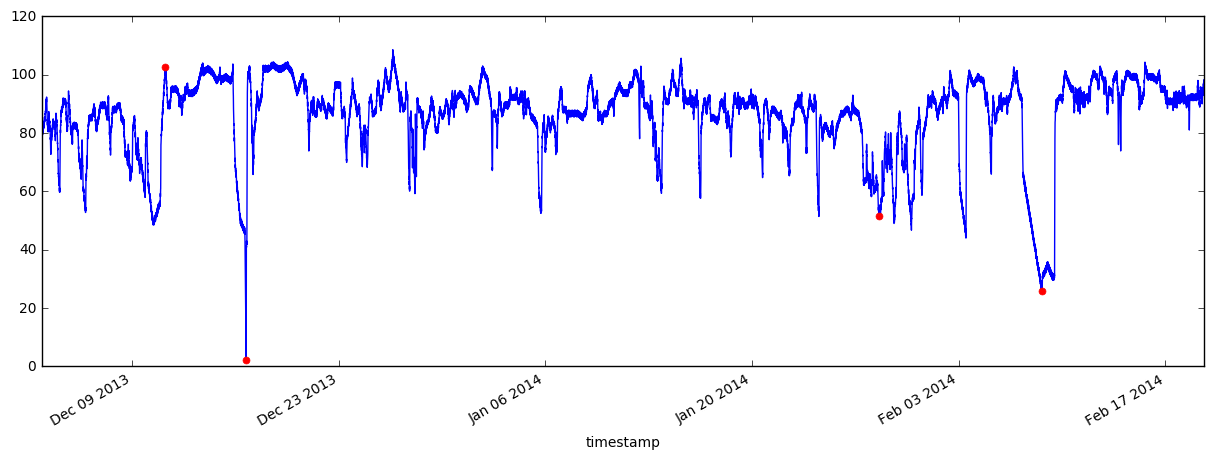

In [124]:
plt.figure()
df['value'].plot(figsize=(15,5))
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=10.0)
plt.show()

Size of test: 2304
Size of validation1: 1152
Size of validation2: 2304
Size of train: 16935
Total: 22695
Ratio of test: 0.101520
Ratio of validation1: 0.050760
Ratio of validation2: 0.101520
Ratio of train: 0.746200
Pandas(Index=Timestamp('2013-12-11 06:00:00'), value=102.73621350000001, anomaly=1)
Pandas(Index=Timestamp('2013-12-16 17:25:00'), value=2.0847212060000002, anomaly=1)


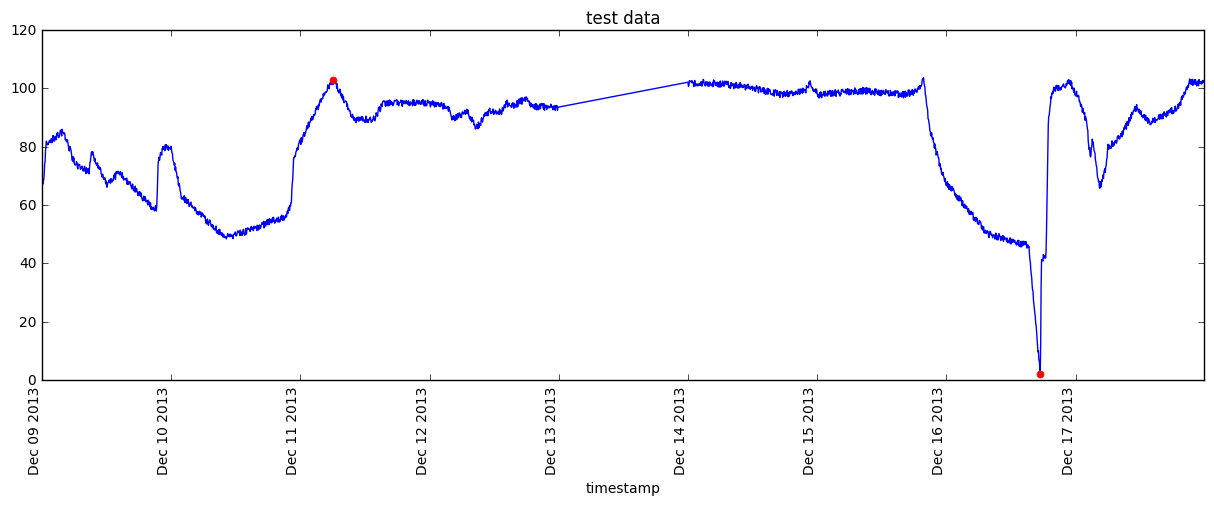

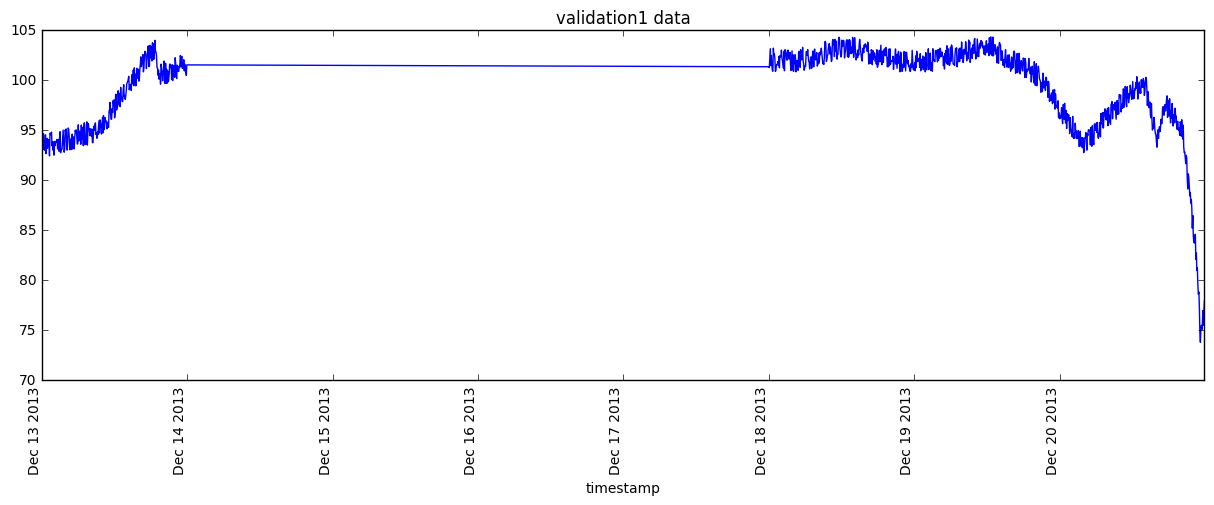

Pandas(Index=Timestamp('2014-01-28 13:55:00'), value=51.36715367, anomaly=1)
Pandas(Index=Timestamp('2014-02-08 14:30:00'), value=25.887752079999999, anomaly=1)


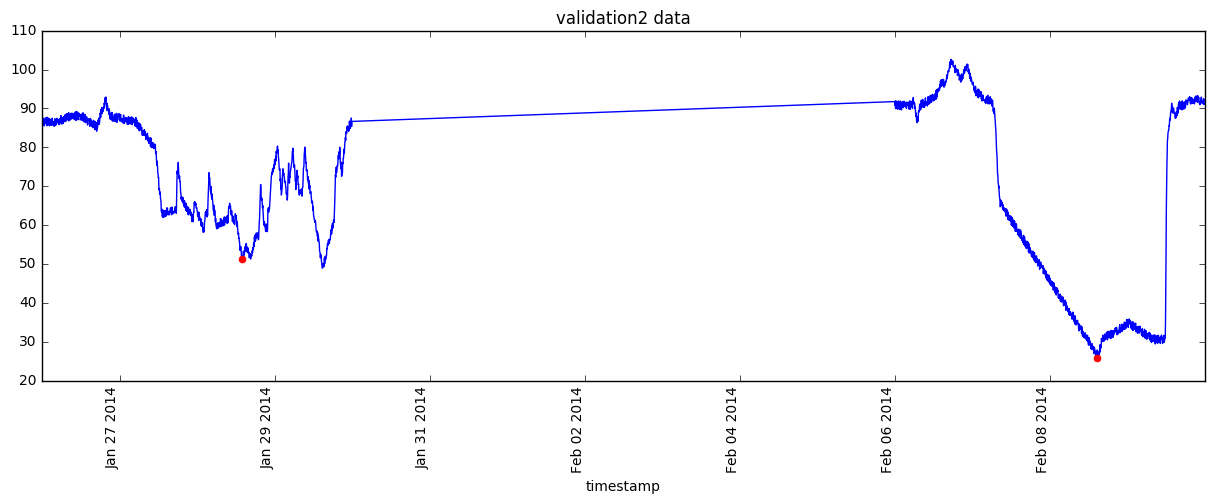

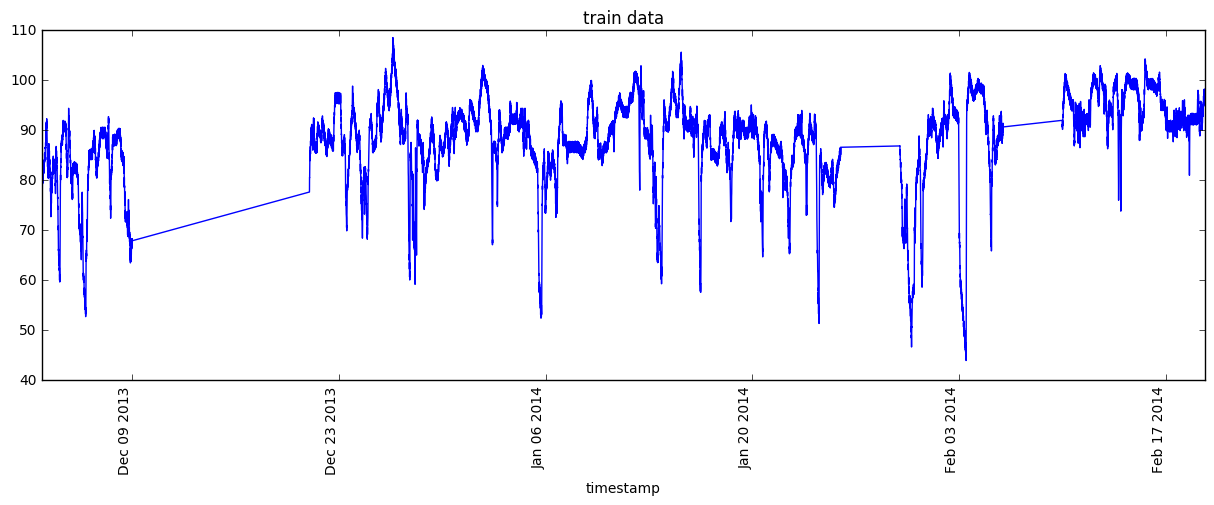

In [125]:
'''
Anomaly Dates: Dec 11, Dec16, Jan28, Feb8
'''
df_validation_prediction = pd.concat([df['2013-12-13'],df['2013-12-18':'2013-12-20']])
df_test = pd.concat([df['2013-12-09':'2013-12-12'],df['2013-12-14':'2013-12-17']])
df_validation_anomaly = pd.concat([df['2014-01-26':'2014-01-29'],df['2014-02-06':'2014-02-09']])
df_not_train = pd.concat([df_validation_prediction,df_validation_anomaly,df_test])
df_train = df[~df.isin(df_not_train)].dropna()

df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation_prediction
df_dict['validation2'] = df_validation_anomaly

count = 0
for key in df_dict:
    print "Size of %s: %d"%(key,df_dict[key].shape[0])
    count += df_dict[key].shape[0]
print "Total: %d"%(count)

for key in df_dict:
    print "Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count)

    
for key in df_dict:
    df_tmp = df_dict[key]
    plt.figure()
    df_tmp['value'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        print row
        plt.plot(row[0], row[1], 'r.', markersize=10.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [126]:
for key in df_dict:
    np.save("../resources/data/nab/nab_machine_temperature/%s"%(key),df_dict[key])

In [ ]:
## code below this not used

In [127]:
train = np.load("../resources/data/nab/nab_machine_temperature/train.npy")
validation1 = np.load("../resources/data/nab/nab_machine_temperature/validation1.npy")
validation2 = np.load("../resources/data/nab/nab_machine_temperature/validation2.npy")
test = np.load("../resources/data/nab/nab_machine_temperature/test.npy")
test_orig = test

In [128]:
print sum(train[:,1])
print sum(validation1[:,1])
print sum(validation2[:,1])
print sum(test[:,1])

0.0
0.0
2.0
2.0


In [129]:


data_folder = "../resources/data/nab/nab_machine_temperature/"
train = np.load(data_folder+"train.npy")
validation1 = np.load(data_folder+"validation1.npy")
validation2 = np.load(data_folder+"validation2.npy")
test = np.load(data_folder + "test.npy")


train,train_scaler = standardize(train[:,0])
validation1,validation1_scaler = standardize(validation1[:,0])
validation2_labels = validation2[:,1]
validation2,validation2_scaler = standardize(validation2[:,0])
test_labels = test[:,1]
test,test_scaler = standardize(test[:,0])

look_back = 5 
look_ahead = 3
X_train, y_train = prepare_seq2seq_data(train,look_back,look_ahead)
X_validation1, y_validation1 =  prepare_seq2seq_data(validation1,look_back,look_ahead)
X_validation2, y_validation2 =  prepare_seq2seq_data(validation2,look_back,look_ahead)
X_validation2_labels,y_validation2_labels = prepare_seq2seq_data(validation2_labels,look_back,look_ahead)
X_test, y_test = prepare_seq2seq_data(test,look_back,look_ahead)
X_test_labels,y_test_labels = prepare_seq2seq_data(test_labels,look_back,look_ahead)



NameError: name 'standardize' is not defined

In [ ]:
#verify
print test_orig[440:460]
X_test = test_scaler.inverse_transform(X_test)
y_test = test_scaler.inverse_transform(y_test)
print X_test[440:460]
print y_test[440:460]


In [ ]:
print X_test_labels[440:460]
print y_test_labels[440:460]

In [ ]:
plt.figure()
plt.plot(range(1,len(y_test)+1),y_test[:,0])
anomalies = np.where(y_test_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_test[row,0], 'r.', markersize=10.0)
plt.show()

In [ ]:
plt.figure()
plt.plot(range(1,len(y_validation2)+1),y_validation2[:,0])
anomalies = np.where(y_validation2_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_validation2[row,0], 'r.', markersize=10.0)
plt.show()

In [ ]:
plt.figure()
plt.plot(range(1,len(y_validation1)+1),y_validation1[:,0])
plt.show()

In [130]:
#Detection code starts here
#Detection code starts here
#Detection code starts here
#Detection code starts here

In [131]:
data_folder = "../resources/data/nab/nab_machine_temperature/"

In [132]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print train_predictions.shape
print train_true.shape


(16922, 12)
(16922,)


In [133]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print np.shape(validation2_predictions)
print np.shape(validation2_true)
print np.shape(validation2_labels)
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print np.shape(validation2_labels)


(2291, 12)
(2291,)
(2291, 12, 1)
(2291, 12)


In [134]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print np.shape(test_predictions)
print np.shape(test_true)
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print np.shape(test_labels)

(2291, 12)
(2291,)
(2291, 12)


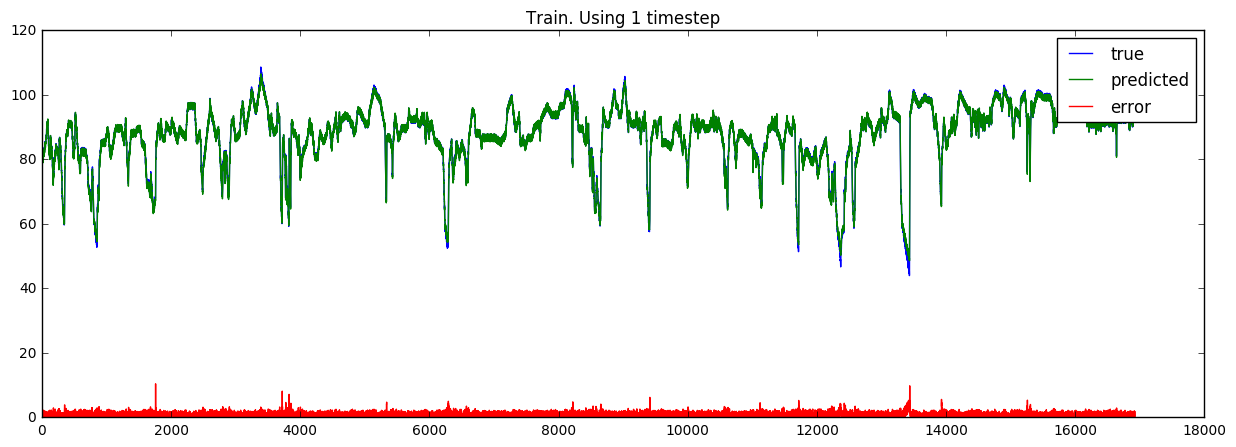

In [135]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[ 0.06178182  0.06312889  0.06442522  0.06561802  0.06677684  0.06774529
  0.06874057  0.06974622  0.07067083  0.07154928  0.07253314  0.07339313]
[[  1.24551698   0.90594678   1.00270269   1.09855128   1.17181075
    1.20482536   1.24608248   1.2573873    1.2923674    1.28917683
    1.30424757   1.29218496]
 [  0.90594678   1.68928337   1.44734269   1.64198969   1.81511468
    1.92783479   2.00913031   2.06994975   2.12421924   2.16504029
    2.18515152   2.19639439]
 [  1.00270269   1.44734269   2.32836625   2.18424876   2.45600648
    2.66845144   2.82950271   2.93040992   3.0342048    3.09432089
    3.15844141   3.17480556]
 [  1.09855128   1.64198969   2.18424876   3.16331366   3.09623041
    3.40715655   3.66800826   3.84860504   3.99244584   4.10205769
    4.18550001   4.24584455]
 [  1.17181075   1.81511468   2.45600648   3.09623041   4.15300856
    4.12519869   4.48459745   4.76462269   4.98827717   5.13800146
    5.2709508    5.35068239]
 [  1.20482536   1.92783479   2.668451

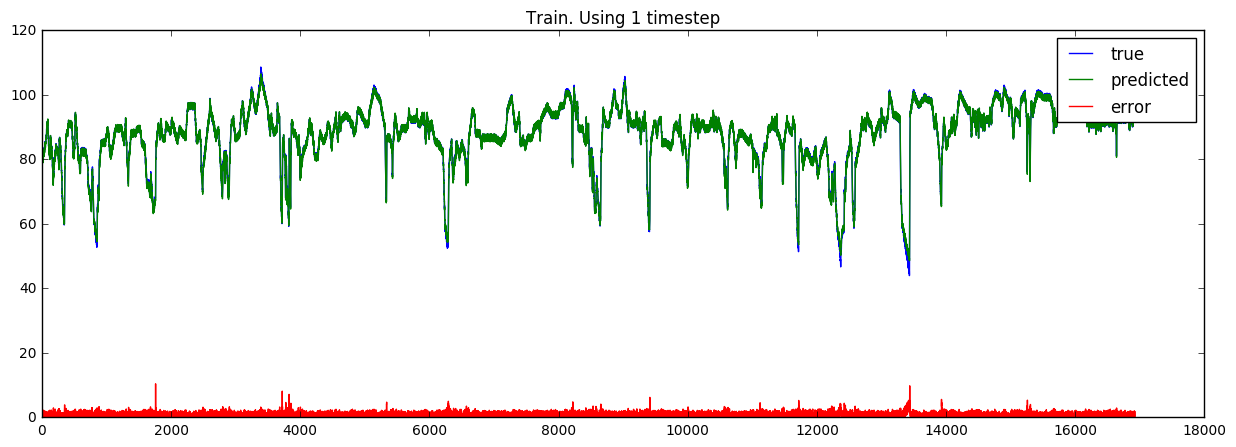

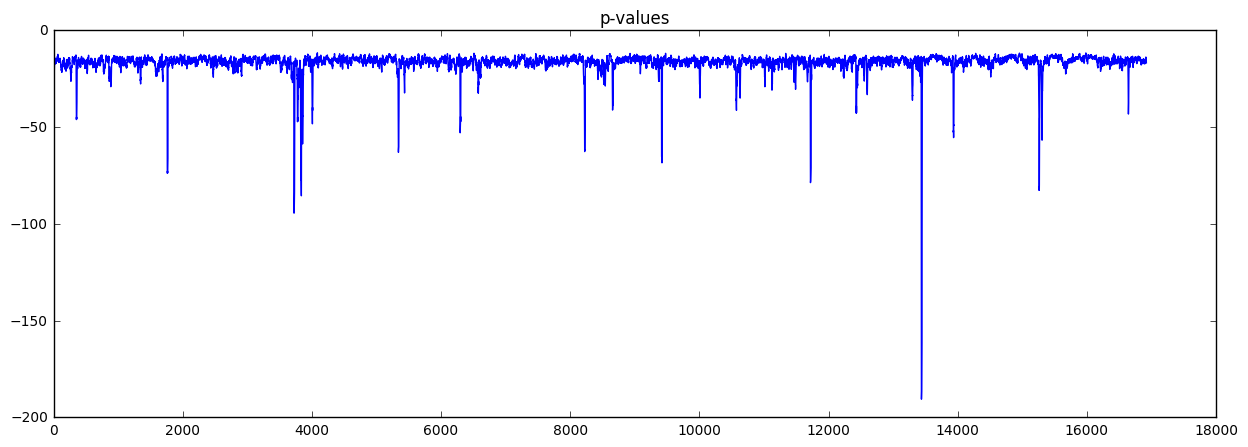

In [182]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print mean
print cov
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [183]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
v2_true_anomalies = np.where(validation2_labels[:,0]==1)
print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
v2_thresholds =v2_p_values[v2_true_anomalies]
print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
print "Test. Location of anomalies: %s"%(test_true_anomalies)
print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
test_thresholds = test_p_values[test_true_anomalies]
print "Test. p-values at true anomalies: %s"%(test_thresholds)





Validation2. Number True Anomalies: 2
Validation2. Location of anomalies: [ 742 1901]
validation2. True anomalies: [ 51.36715367  25.88775208]
validation2. p-values at true anomalies: [-16.15516783 -99.8104043 ]

Test. Number True Anomalies in: 2
Test. Location of anomalies: [ 647 1936]
Test. True anomalies: [ 102.7362135     2.08472121]
Test. p-values at true anomalies: [ -15.55945039 -402.86884469]


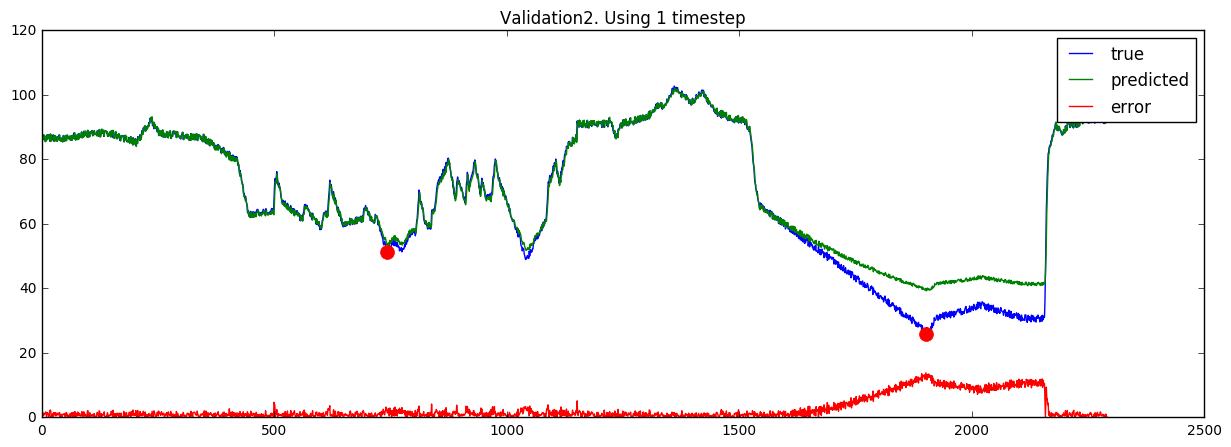

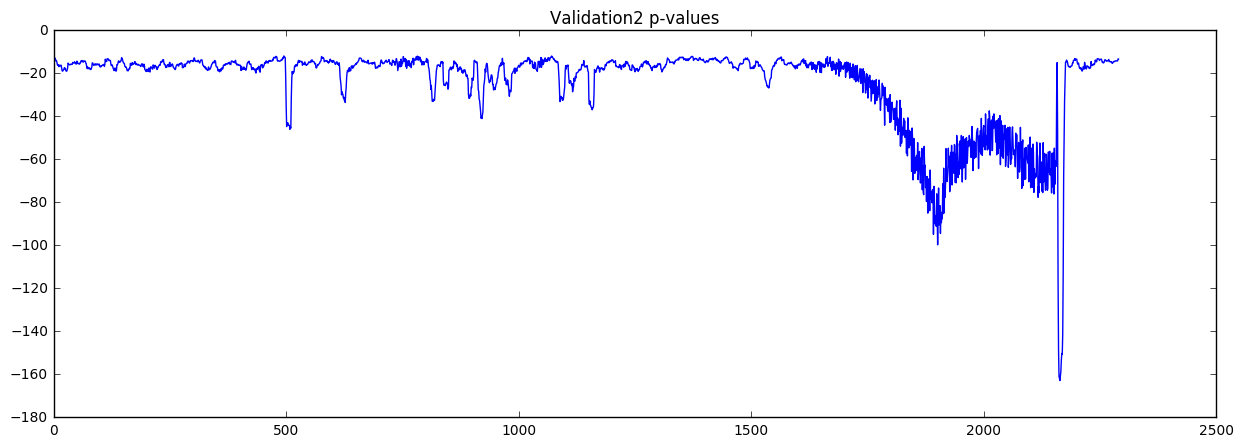

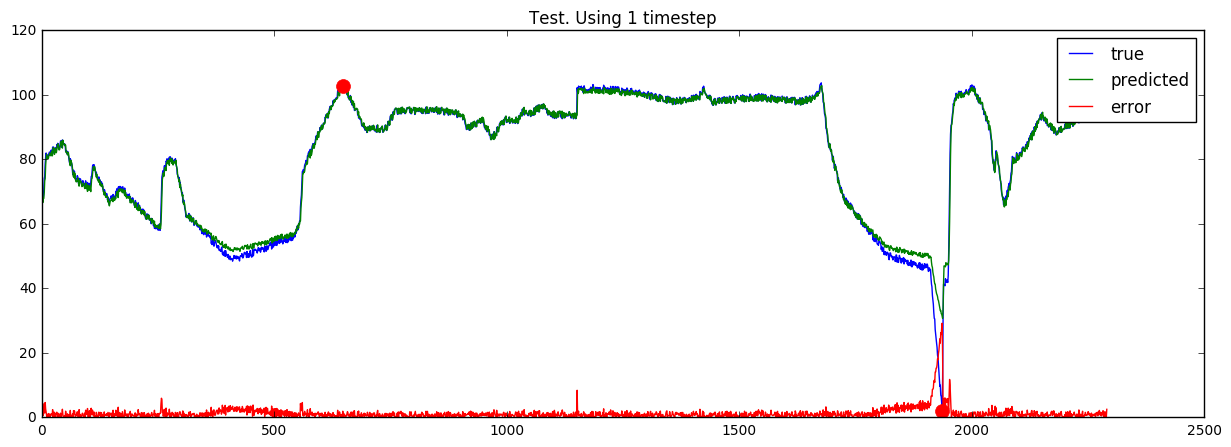

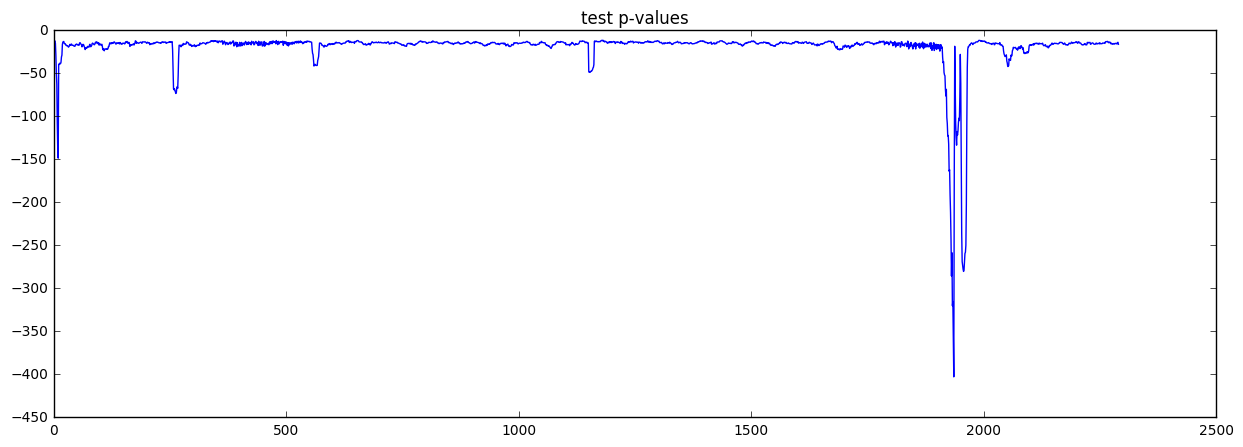

In [138]:
plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,0],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(v2_p_values)
plt.title("Validation2 p-values")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,0],label='predicted')
plt.plot(abs(test_true - test_predictions[:,0]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_p_values)
plt.title("test p-values")
plt.show()


Candidate Thresholds: [-40, -45, -50]


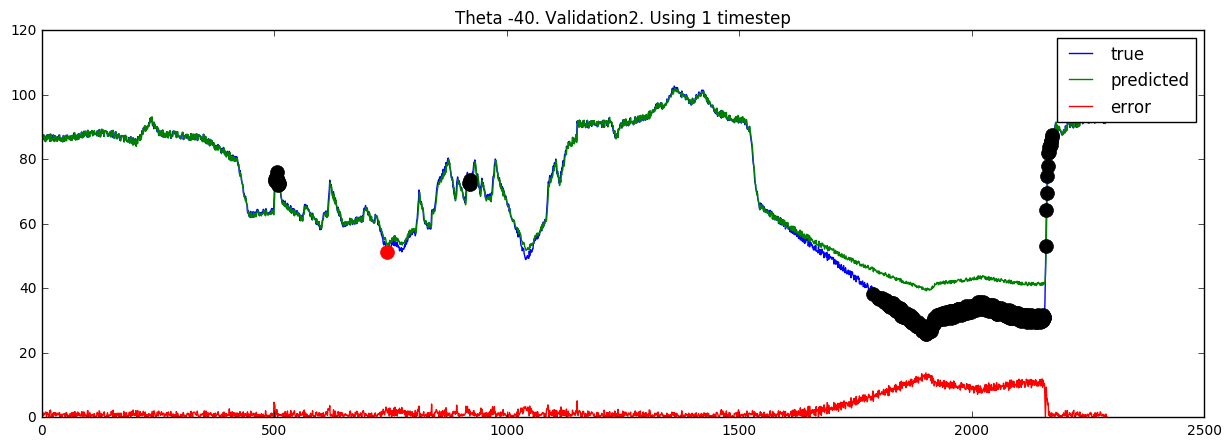

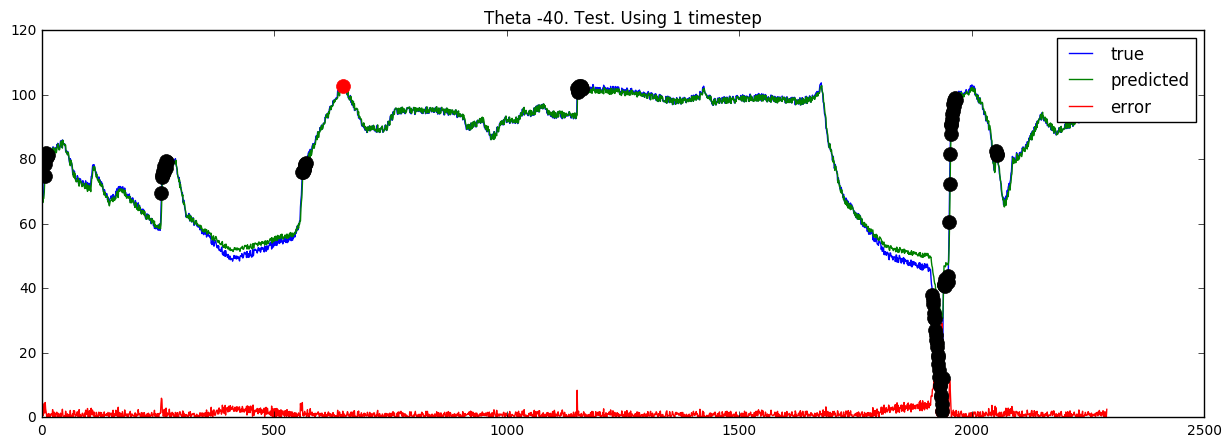

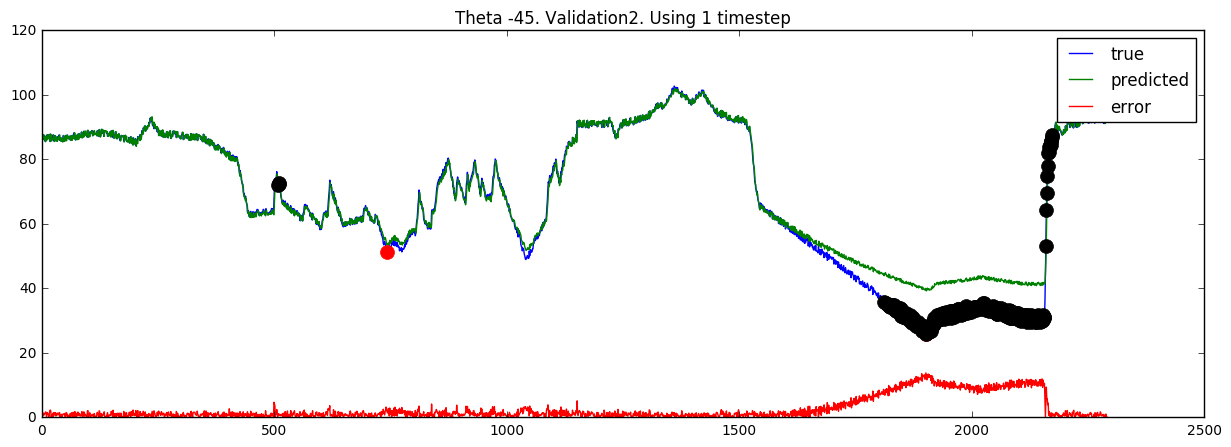

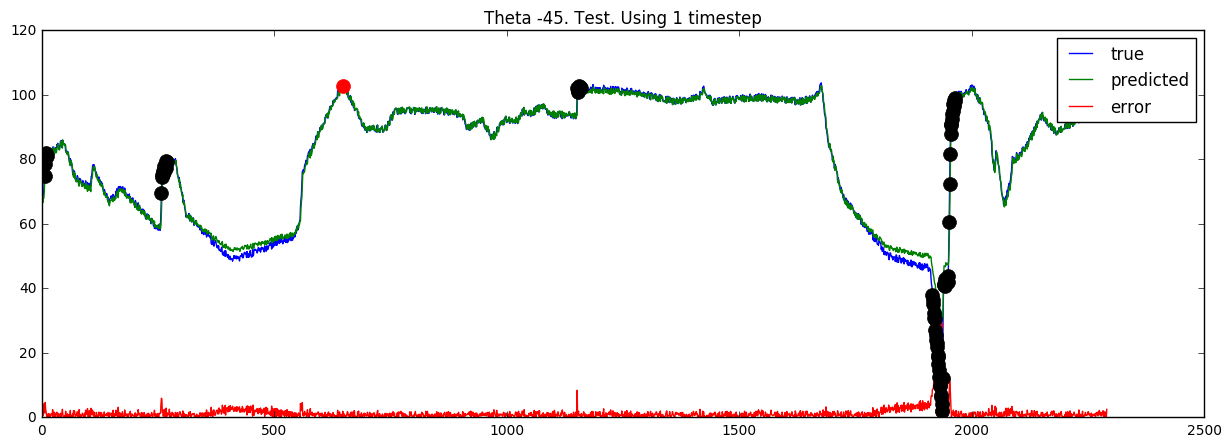

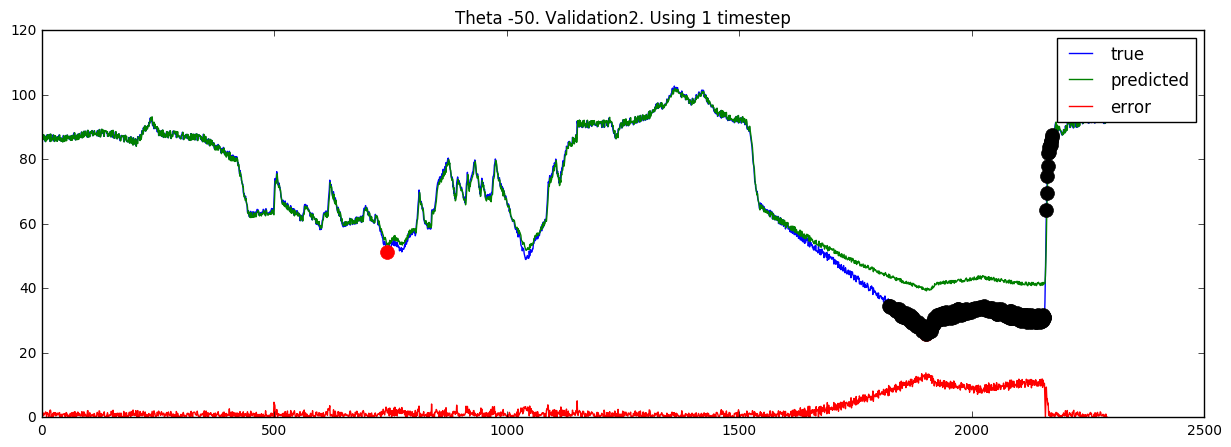

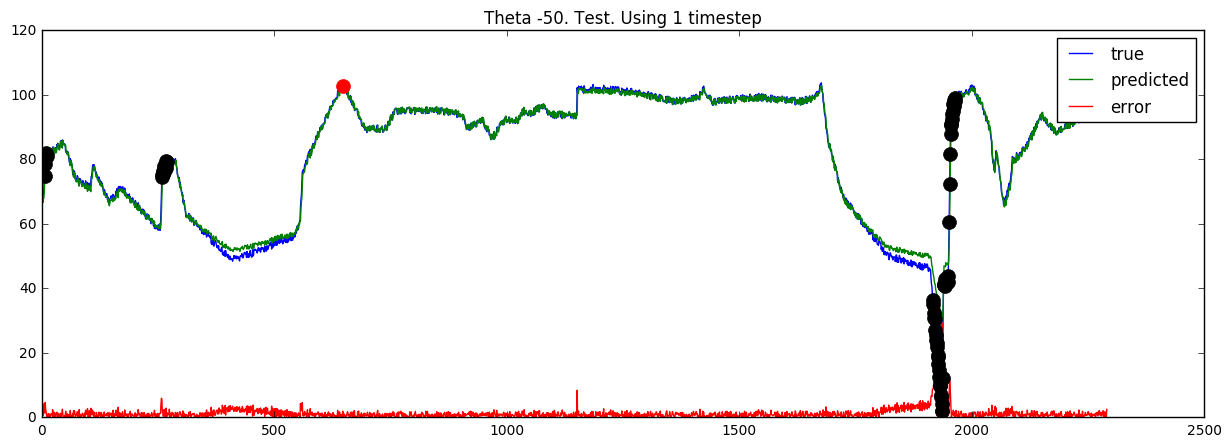

In [178]:
#thresholds = np.append(v2_thresholds,test_thresholds)

#thresholds =v2_thresholds
thresholds =[-40,-45,-50]
print
print "Candidate Thresholds: %s"%(thresholds)


for i in thresholds:
    theta= i
    test_potential_anomalies = np.where(test_p_values <= theta)
    v2_potential_anomalies = np.where(v2_p_values <= theta)
    plt.figure(figsize=(15,5))
    plt.plot(validation2_true,label='true')
    plt.plot(validation2_predictions[:,0],label='predicted')
    plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
    for row in v2_true_anomalies:
        plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
    for row in v2_potential_anomalies:
        plt.plot(row, validation2_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Validation2. Using 1 timestep"%(i))
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_true,label='true')
    plt.plot(test_predictions[:,0],label='predicted')
    plt.plot(abs(test_true - test_predictions[:,0]),label='error')
    for row in test_true_anomalies:
        plt.plot(row, test_true[row], 'r.', markersize=20.0)
    for row in test_potential_anomalies:
        plt.plot(row, test_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Test. Using 1 timestep"%(i))
    plt.show()





In [181]:
theta= -50
test_predicted_anomalies = test_p_values <= theta
v2_predicted_anomalies = [1 if x <= theta else 0 for x in v2_p_values]
print np.shape(validation2_labels)
print fbeta_score(validation2_labels[:,0],v2_predicted_anomalies,pos_label=0, average='binary', beta=.5)
print 

(2291, 12)
0.972504598703



In [ ]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]
# print validation2_predictions[100:102]
# print validation2_true[100:102]
# print v2_error_vectors[100:102]
print np.shape(train_error_vectors)
mean = np.mean(train_error_vectors, axis=0)
print mean
cov = np.cov(train_error_vectors,rowvar=False)
print np.shape(cov)
p_values= multivariate_normal.pdf(train_error_vectors,mean,cov)
print p_values
print np.shape(p_values)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

In [78]:
print validation2_predictions[100]
print validation2_true[100]

[ 72.47651672  72.26094055  72.51985168  72.72478485  73.03216553
  73.40619659]
74.41085847


In [79]:
print validation2_predictions[100] - validation2_true[100]

[-1.93434143 -2.1499176  -1.89100647 -1.6860733  -1.37869263 -1.00466156]


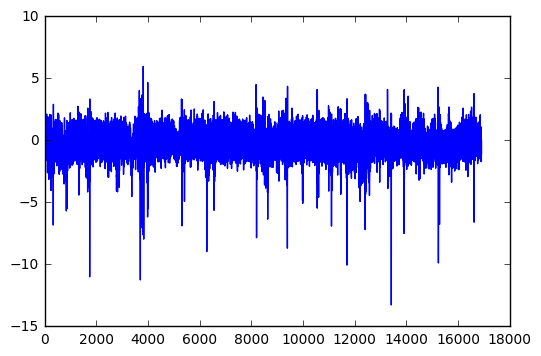

In [80]:
#using prediction intervals
#use first timestep
from scipy.stats import t
p = 95
alpha = (100-p)/100

train_errors = train_predictions[:,0] - train_true
n = np.shape(train_errors)[0]
s =  np.std(train_errors)
plt.plot(train_errors)
plt.show()
